# Algoritmo de Grove para 3-bit

In [1]:
# Importando as bibliotecas necessárias
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import matplotlib.pyplot as plt

# Para exibir gráficos no Jupyter Notebook
%matplotlib inline

## Definição de funções

In [2]:
def grover_oracle(circuit: QuantumCircuit, marked_state_str: str):
    """
    Implementa o oráculo de Grover para marcar um estado específico.
    O oráculo inverte a fase do estado marcado |marked_state_str⟩.

    Args:
        circuit (QuantumCircuit): O circuito quântico onde o oráculo será aplicado.
        marked_state_str (str): O estado binário a ser marcado (ex: '110' para 3 qubits). A string é lida como Big Endian (q_n-1 ... q_0).
    """
    n = circuit.num_qubits

    # 1. Aplicar portas X para converter '0's em '1's para o estado marcado
    #    Isso transforma o estado marcado em |11...1⟩ para o MCZ gate.
    #    A indexação da string é MSB-first (q_n-1 ... q_0), enquanto o Qiskit é LSB-first (q0 ... q_n-1). 
    # marked_state_str[n - 1 - i] acessa o bit de q_i.
    for i in range(n):
        if marked_state_str[n - 1 - i] == '0':
            circuit.x(i)

    # 2. Aplicar uma porta MCZ (Multi-Controlled Z).
    #    Para 3 qubits, é uma CCZ implementada como H + MCX + H.
    #    A MCX atua como uma Toffoli de 2 controles.
    #    q(0) e q(1) atuam sobre q(2)
    circuit.h(n - 1) # H no qubit mais significativo (target da MCX)
    circuit.mcx(list(range(n - 1)), n - 1) # MCX com q0, q1 como controles e q2 como target
    circuit.h(n - 1) # H no qubit mais significativo

    # 3. Reverter as portas X aplicadas no passo 1
    for i in range(n):
        if marked_state_str[n - 1 - i] == '0':
            circuit.x(i)
    circuit.barrier() # Barreira para visualização

In [3]:
def grover_diffuser(circuit: QuantumCircuit):
    """
    Implementa o operador difusor (inversão em torno da média).
    Amplifica a amplitude do estado marcado e diminui as amplitudes dos outros estados.

    Args:
        circuit (QuantumCircuit): O circuito quântico onde o difusor será aplicado.
    """
    n = circuit.num_qubits

    # 1. Aplicar Hadamard a todos os qubits
    circuit.h(range(n))
    # 2. Aplicar X a todos os qubits
    circuit.x(range(n))

    # 3. Aplicar um MCZ (Multi-Controlled Z) gate que inverte a fase do estado |11...1⟩
    # É o mesmo padrão H + MCX + H do oráculo.
    circuit.h(n - 1) # H no qubit mais significativo
    circuit.mcx(list(range(n - 1)), n - 1) # MCX com q0, q1 como controles e q2 como target
    circuit.h(n - 1) # H no qubit mais significativo

    # 4. Reverter as X
    circuit.x(range(n))
    # 5. Reverter as H
    circuit.h(range(n))
    circuit.barrier()


## Início do código

In [4]:
# Definição dos Parâmetros do Algoritmo
n_qubits = 3  # Número de qubits
marked_state = '110' # O estado que queremos encontrar

# O número de estados na base de busca
N = 2**n_qubits

# Assumimos que há apenas 1 estado marcado (M=1) para este exemplo
M = 1

# Calculando o número ótimo de iterações (arredondado para o inteiro mais próximo)
# aproximadamente (pi/4) * sqrt(N/M)
num_iterations = int(np.round(np.pi / 4 * np.sqrt(N / M)))
print(f"Número de qubits: {n_qubits}")
print(f"Número total de estados (N): {N}")
print(f"Estado marcado: |{marked_state}⟩")
print(f"Número ótimo de iterações do Grover: {num_iterations}\n")

Número de qubits: 3
Número total de estados (N): 8
Estado marcado: |110⟩
Número ótimo de iterações do Grover: 2



In [5]:
# Criação do Circuito Quântico
# O circuito terá n_qubits qubits quânticos e n_qubits bits clássicos para medição
qc = QuantumCircuit(n_qubits, n_qubits)


In [6]:
# Inicialização para Superposição Uniforme
# Aplica uma porta Hadamard (H) a cada qubit.
# Isso coloca todos os qubits em uma superposição uniforme de todos os 2^n estados possíveis.
# Cada estado tem uma amplitude de 1/sqrt(N).
qc.h(range(n_qubits))
qc.barrier() # Barreira para visualização clara no circuito

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(<Qubit register=(3, "q"), index=0>, <Qubit register=(3, "q"), index=1>, <Qubit register=(3, "q"), index=2>), clbits=())

In [7]:
# Loop das Iterações do Grover
for i in range(num_iterations): 
    print(f"Aplicando iteração Grover {i+1}/{num_iterations}...")
    grover_oracle(qc, marked_state)
    grover_diffuser(qc)

Aplicando iteração Grover 1/2...
Aplicando iteração Grover 2/2...


In [8]:
# Medição
# Mede todos os qubits quânticos e armazena os resultados nos bits clássicos.
qc.measure(range(n_qubits), range(n_qubits))

Circuito Final do Algoritmo de Grover:


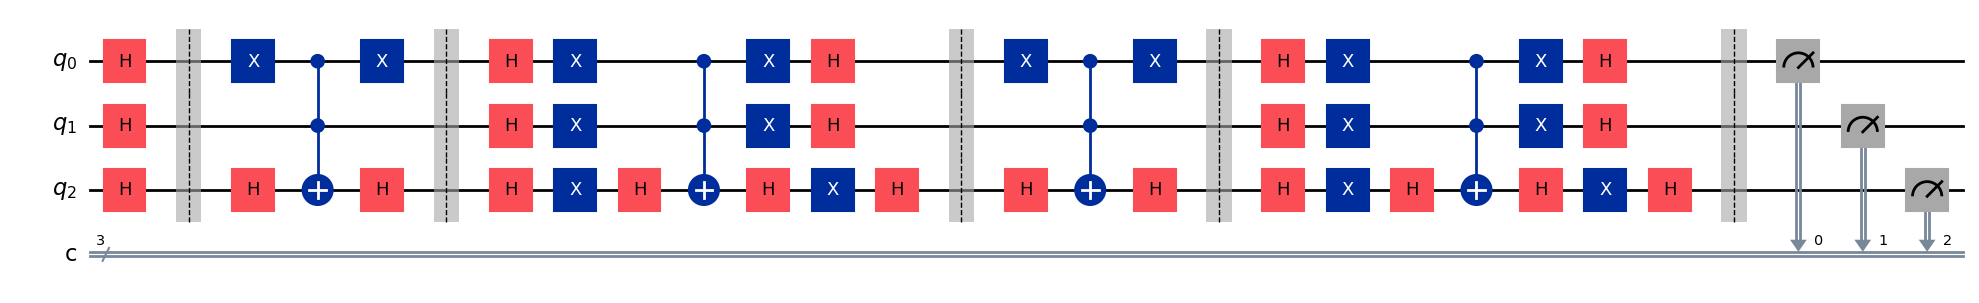

In [9]:
# Visualização do Circuito Final
print("Circuito Final do Algoritmo de Grover:")
# Desenha o circuito. 'mpl' para visualização em matplotlib.
# 'fold=-1' para evitar que o circuito seja dobrado em múltiplas linhas
qc.draw('mpl', fold=-1, filename='grover_circuit.png')
plt.show()

In [10]:
# Execução no Simulador
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

# Executa o circuito no simulador com um grande número de shots
shots = 10000
job = simulator.run(compiled_circuit, shots=shots)
result = job.result()
counts = result.get_counts(qc)

print("\nResultados das Medições:")
print(counts)


Resultados das Medições:
{'011': 86, '111': 80, '010': 83, '000': 83, '101': 82, '100': 64, '001': 77, '110': 9445}


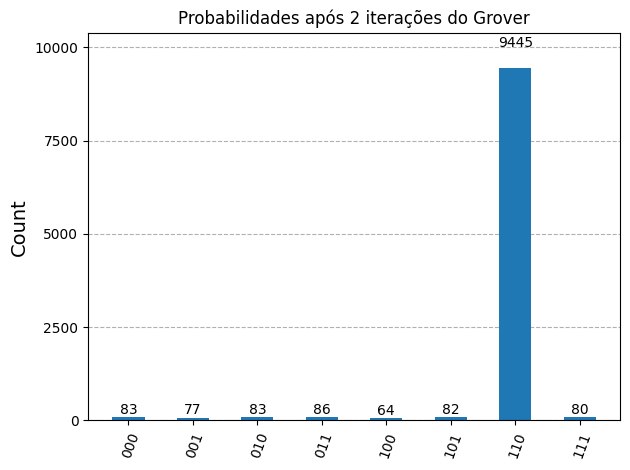

In [11]:
# Plotagem das Probabilidades
plot_histogram(counts, title=f"Probabilidades após {num_iterations} iterações do Grover")
plt.show()



Circuito para Statevector sem medições:


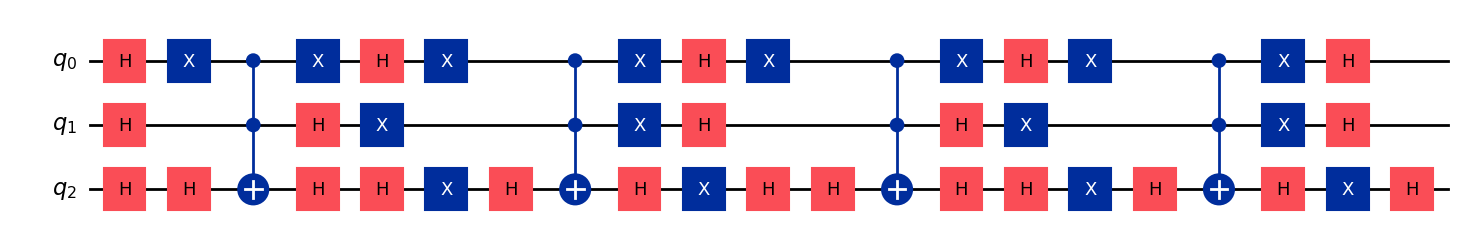

In [12]:
# Verificação do Statevector antes da medição
# Este passo não faz parte do algoritmo real, foi só para análise.
from qiskit.quantum_info import Statevector

# Recria o circuito sem medições para verificar o statevector
qc_statevector_manual = QuantumCircuit(n_qubits)
qc_statevector_manual.h(range(n_qubits))

for _ in range(num_iterations):
    # Oráculo (copiado do circuito principal)
    if marked_state[2] == '0': qc_statevector_manual.x(0)
    if marked_state[1] == '0': qc_statevector_manual.x(1)
    if marked_state[0] == '0': qc_statevector_manual.x(2)
    qc_statevector_manual.h(n_qubits - 1)
    qc_statevector_manual.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc_statevector_manual.h(n_qubits - 1)
    if marked_state[2] == '0': qc_statevector_manual.x(0)
    if marked_state[1] == '0': qc_statevector_manual.x(1)
    if marked_state[0] == '0': qc_statevector_manual.x(2)

    # Difusor (copiado do circuito principal)
    qc_statevector_manual.h(range(n_qubits))
    qc_statevector_manual.x(range(n_qubits))
    qc_statevector_manual.h(n_qubits - 1)
    qc_statevector_manual.mcx(list(range(n_qubits - 1)), n_qubits - 1)
    qc_statevector_manual.h(n_qubits - 1)
    qc_statevector_manual.x(range(n_qubits))
    qc_statevector_manual.h(range(n_qubits))

print("\nCircuito para Statevector sem medições:")
qc_statevector_manual.draw('mpl', fold=-1, filename='grover_statevector_manual_circuit.png')
plt.show()


Statevector Final:
[-0.08838835+0.j -0.08838835+0.j -0.08838835+0.j -0.08838835+0.j
 -0.08838835+0.j -0.08838835+0.j  0.97227182+0.j -0.08838835+0.j]


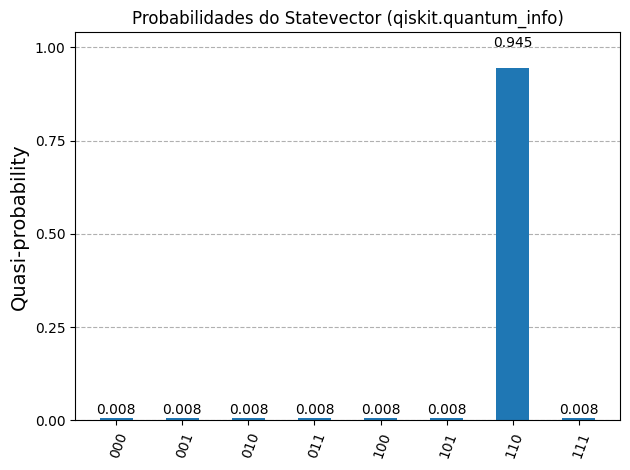

In [13]:
# Inicializa um statevector no estado |000⟩
initial_state = Statevector.from_int(0, dims=2**n_qubits)

# Aplica o circuito ao statevector inicial
final_statevector = initial_state.evolve(qc_statevector_manual)

print("\nStatevector Final:")
print(final_statevector.data) # .data para acessar o array numpy embutido

# Calcula as probabilidades a partir do statevector
probabilities = np.abs(final_statevector.data)**2

# Cria um dicionário para plotar com nomes de estados
state_names = [format(i, '03b') for i in range(N)] # '03b' para 3 bits binários
prob_dict = {state_names[i]: prob for i, prob in enumerate(probabilities)}

plot_histogram(prob_dict, title="Probabilidades do Statevector (qiskit.quantum_info)")
plt.show()